<a href="https://colab.research.google.com/github/mihir1125/machine-learning/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TODO
# [ ] Shuffled variant

import numpy as np
import tensorflow as tf
from math import ceil, floor
from itertools import accumulate

import matplotlib.pyplot as plt

In [ ]:
#@title Helper Functions

def get_pieces(n, k):
    piece = n // k
    remainder = n % k
    arr = np.full((k,), piece)
    arr[:remainder] += np.ones(remainder, dtype=np.int64)
    return arr

def load_data(size = 120, *, shuffle = False):
    SIZE_pos = (int)(size / 2)
    SIZE_neg = size - SIZE_pos
    rng = np.random.default_rng(1234) # Seed
    X_train_pos = rng.uniform(
        low = -1.0,
        high = 1.0,
        size = (SIZE_pos, 2)
    )
    y_train_pos = np.ones(SIZE_pos)

    # Get negative Y data
    # Apporximately equally distributed
    # for all 4 quadrants
    quadrants = ((1, 1), (-1, 1), (-1, -1), (1, -1))
    X_train_neg = rng.uniform(
        low = 1.0,
        high = 2.0,
        size = (SIZE_neg, 2)
    )

    zipped = zip(quadrants, accumulate(get_pieces(SIZE_neg, 4)))
    start = 0
    for quadrant, index in zipped:
        X_train_neg[start:index] *= quadrant
        start = index

    y_train_neg = np.zeros(SIZE_neg)
    X_train = np.append(X_train_pos, X_train_neg, axis = 0)
    y_train = np.append(y_train_pos, y_train_neg, axis = 0)

    if shuffle:
        shuffled_indices = np.arange(size)
        rng.shuffle(shuffled_indices)
        X_train_shuffled = X_train[shuffled_indices]
        y_train_shuffled = y_train[shuffled_indices]
        return X_train_shuffled, y_train_shuffled

    return X_train, y_train

    def sigmoid(z):
        g = 1 / (1 + np.exp(-z))
        return g

    def compute_cost_logistic(model_func, X, y, w, b):
        f_wb = map(model_fun, X, w, b,)
        pass

    def compute_gradient_logistic():
        pass

### Unshuffled

X_train_pos: (100, 2), y_train_pos: (100,)
X_train_neg: (100, 2), y_train_neg: (100,)


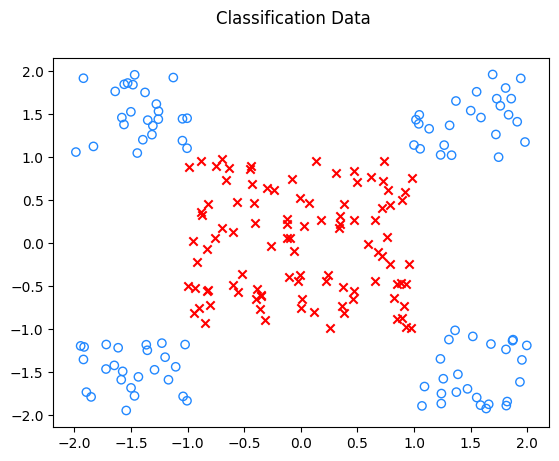

In [ ]:
# Load data, unshuffled
X_train, y_train = load_data(200)

positive_indices = y_train == 1.
negative_indices = y_train == 0.

X_train_pos = X_train[positive_indices]
y_train_pos = y_train[positive_indices]
X_train_neg = X_train[negative_indices]
y_train_neg = y_train[negative_indices]

# Visualize
print(f"X_train_pos: {X_train_pos.shape}, y_train_pos: {y_train_pos.shape}")
print(f"X_train_neg: {X_train_neg.shape}, y_train_neg: {y_train_neg.shape}")
## Positives
fig, ax = plt.subplots()
ax.scatter(X_train_pos[:, 0], X_train_pos[:, 1], marker='x', c='red')
ax.scatter(X_train_neg[:, 0], X_train_neg[:, 1], facecolors='none', edgecolors='#2288FF')
fig.suptitle("Classification Data")
plt.show()